# Libs and pre-definitions

### Bibliotecas padrões python e utils pytorch

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from collections import defaultdict
from torch.utils.data import random_split
import copy

In [2]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [3]:
import NN_models as models
import uncertainty.comparison as unc_comp
import uncertainty.quantifications as unc
import uncertainty.losses as losses
import uncertainty.train_and_eval_with_g as TE_g
import NN_utils as utils
import NN_utils.train_and_eval as TE

## Data download and transforms

In [4]:
transforms_train = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transforms_test = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [5]:
training_data = datasets.CIFAR10(
root="data",
 train=True,
 download=True,
transform=transforms_train)

test_data = datasets.CIFAR10(
root="data",
train=False,
download=True,
transform=transforms_test)

train_size = int(0.85*len(training_data))
val_size = len(training_data) - train_size
training_data, validation_data = random_split(training_data, [train_size, val_size])

validation_data = copy.deepcopy(validation_data)
validation_data.dataset.transform = transforms_test

Files already downloaded and verified
Files already downloaded and verified


In [6]:
batch_size = 100
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size,shuffle = False)
test_dataloader = DataLoader(test_data, batch_size=100)

# Train classifier

In [7]:
loss_criterion = nn.NLLLoss(reduction = 'none')

loss_fn = losses.selective_net_2(loss_criterion,const_var = 'g')

risk_dict = {'empirical_risk':losses.selective_net_2(loss_criterion,optim_method = None,head = None,alpha = 1),
             'bce_risk':lambda x,label: torch.mean(loss_criterion(x[0],label)),
             'constraint':lambda x,label: loss_fn.get_constraint(losses.normalize_tensor(x[1])),
             'selective_risk_g':lambda x,label: unc_comp.selective_risk(x,label,unc_type = 'g'),
            'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x[0],label,unc_type = unc.MCP_unc)}

In [8]:
#model with auxiliary head 'h' defined paralell to the classifier.
model_h = models.Model_CNN_with_g_and_h(10).cuda()
optimizer = torch.optim.SGD(model_h.parameters(), lr=1e-3,momentum = 0.9)
loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = losses.selective_net_2(loss_criterion,c_fn = losses.entropy_const,const_var = 'w',head = model_h.get_h,alpha = 0.5)

model_trainer_h = TE_g.Trainer_with_g(model_h,optimizer,loss_fn, train_dataloader,validation_dataloader,c=0.8,risk_dict = risk_dict)
model_trainer_h.fit(train_dataloader,1000)
#state_dict  = model_h.state_dict()

model_h.return_g = False
acc = TE.model_acc(model_h,train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model_h,test_dataloader)
print('Conjunto de teste: acc = ', acc)

Epoch  1 , loss =  2.1651638561136584
Epoch  2 , loss =  1.9076948160283707
Epoch  3 , loss =  1.7157951761694517
Epoch  4 , loss =  1.5706710795795216
Epoch  5 , loss =  1.4921387815475464
Epoch  6 , loss =  1.446321424035465
Epoch  7 , loss =  1.3966189695807065
Epoch  8 , loss =  1.3627678663590375
Epoch  9 , loss =  1.3298923627068016
Epoch  10 , loss =  1.2959236052457024
Epoch  11 , loss =  1.261899616017061
Epoch  12 , loss =  1.22595303142772
Epoch  13 , loss =  1.1988735100802252
Epoch  14 , loss =  1.1702383463522967
Epoch  15 , loss =  1.141530913885902
Epoch  16 , loss =  1.1195882811265834
Epoch  17 , loss =  1.0954094119632944
Epoch  18 , loss =  1.075831922783571
Epoch  19 , loss =  1.053898578671848
Epoch  20 , loss =  1.032884049836327
Epoch  21 , loss =  1.0197859081100016
Epoch  22 , loss =  0.9972522710351382
Epoch  23 , loss =  0.975645546352162
Epoch  24 , loss =  0.9646023305724649
Epoch  25 , loss =  0.9529976973814123
Epoch  26 , loss =  0.9344546311041888
Epoc

In [9]:
#model with auxiliary head as the main classifier
model_f = models.Model_CNN_with_g(10).cuda()
optimizer = torch.optim.SGD(model_f.parameters(), lr=1e-3,momentum = 0.9)
loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = losses.selective_net_2(loss_criterion,c_fn = losses.entropy_const,const_var = 'w',head = 'y',alpha = 0.5)

model_trainer_f = TE_g.Trainer_with_g(model_f,optimizer,loss_fn, train_dataloader,validation_dataloader,c=0.8,risk_dict = risk_dict)
model_trainer_f.fit(train_dataloader,1000)
#state_dict  = model_h.state_dict()

model_f.return_g = False
acc = TE.model_acc(model_f,train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model_f,test_dataloader)
print('Conjunto de teste: acc = ', acc)

Epoch  1 , loss =  2.128920560724595
Epoch  2 , loss =  1.8632799344904283
Epoch  3 , loss =  1.673331945363213
Epoch  4 , loss =  1.5675276172862334
Epoch  5 , loss =  1.49255898251253
Epoch  6 , loss =  1.4311857745226693
Epoch  7 , loss =  1.3766402331520529
Epoch  8 , loss =  1.3317611447502584
Epoch  9 , loss =  1.3045215486077701
Epoch  10 , loss =  1.2652520373288323
Epoch  11 , loss =  1.2292496915424571
Epoch  12 , loss =  1.1954594474680285
Epoch  13 , loss =  1.1568352717511794
Epoch  14 , loss =  1.1323658901102402
Epoch  15 , loss =  1.0995303013745477
Epoch  16 , loss =  1.0733271931199466
Epoch  17 , loss =  1.0491610975826489
Epoch  18 , loss =  1.0204001820788664
Epoch  19 , loss =  1.0044504995907053
Epoch  20 , loss =  0.9824213406618904
Epoch  21 , loss =  0.9686780312482048
Epoch  22 , loss =  0.9481516195746029
Epoch  23 , loss =  0.9291409005838281
Epoch  24 , loss =  0.917261096870198
Epoch  25 , loss =  0.9016998108695535
Epoch  26 , loss =  0.8896253797587227


In [10]:
#model with auxiliary head as the main classifier
model_nohead = models.Model_CNN_with_g(10).cuda()
optimizer = torch.optim.SGD(model_nohead.parameters(), lr=1e-3,momentum = 0.9)
loss_criterion = nn.NLLLoss(reduction = 'none')
loss_fn = losses.selective_net_2(loss_criterion,c_fn = losses.entropy_const,const_var = 'w')

model_trainer_nohead = TE_g.Trainer_with_g(model_nohead,optimizer,loss_fn, train_dataloader,validation_dataloader,c=0.8,risk_dict = risk_dict)
model_trainer_nohead.fit(train_dataloader,1000)
#state_dict  = model_h.state_dict()

model_nohead.return_g = False
acc = TE.model_acc(model_nohead,train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model_nohead,test_dataloader)
print('Conjunto de teste: acc = ', acc)

Epoch  1 , loss =  2.1593819306878483
Epoch  2 , loss =  1.817692855947158
Epoch  3 , loss =  1.5772338474498075
Epoch  4 , loss =  1.4645534190009621
Epoch  5 , loss =  1.3679674252341776
Epoch  6 , loss =  1.313315440346213
Epoch  7 , loss =  1.263459124845617
Epoch  8 , loss =  1.2105786932215972
Epoch  9 , loss =  1.1537643483105828
Epoch  10 , loss =  1.1183916495828068
Epoch  11 , loss =  1.0707480748961953
Epoch  12 , loss =  1.034151490576127
Epoch  13 , loss =  1.0023742290104136
Epoch  14 , loss =  0.9741757053487441
Epoch  15 , loss =  0.9445402222521165
Epoch  16 , loss =  0.9191566185390248
Epoch  17 , loss =  0.8893852275960585
Epoch  18 , loss =  0.8662701141133028
Epoch  19 , loss =  0.8525942837490755
Epoch  20 , loss =  0.8355265573894276
Epoch  21 , loss =  0.8142971831209519
Epoch  22 , loss =  0.7969484726821675
Epoch  23 , loss =  0.7813555274991428
Epoch  24 , loss =  0.7698766963622149
Epoch  25 , loss =  0.7555735083888558
Epoch  26 , loss =  0.7478115414170657

# Save models

In [13]:
import pickle
PATH = r'/home/luis-felipe/Uncertainty_Estimation/torch_models'
PATH_trainer = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/trainer'

model_trainer_h.hist_val.loss_criterion = None
model_trainer_h.hist_val.risk_dict = None
model_trainer_h.hist_train.loss_criterion = None
model_trainer_h.hist_train.risk_dict = None

model_trainer_f.hist_train.loss_criterion = None
model_trainer_f.hist_train.risk_dict = None
model_trainer_f.hist_val.loss_criterion = None
model_trainer_f.hist_val.risk_dict = None

model_trainer_nohead.hist_train.loss_criterion = None
model_trainer_nohead.hist_train.risk_dict = None
model_trainer_nohead.hist_val.loss_criterion = None
model_trainer_nohead.hist_val.risk_dict = None


torch.save(model_h.state_dict(), PATH + '/new_selective_h')
with open(PATH_trainer + r"/hist_val_new_selective_h_trainer", "wb") as output_file:
    pickle.dump(model_trainer_h.hist_val,output_file)
with open(PATH_trainer + r"/hist_train_new_selective_h_trainer", "wb") as output_file:
    pickle.dump(model_trainer_h.hist_train,output_file)
    
torch.save(model_f.state_dict(), PATH + '/new_selective_f')
with open(PATH_trainer + r"/hist_train_new_selective_f_trainer", "wb") as output_file:
    pickle.dump(model_trainer_f.hist_train,output_file)
with open(PATH_trainer + r"/hist_val_new_selective_f_trainer", "wb") as output_file:
    pickle.dump(model_trainer_f.hist_val,output_file)
    
torch.save(model_nohead.state_dict(), PATH + '/new_selective_nohead')
with open(PATH_trainer + r"/hist_train_new_selective_nohead_trainer", "wb") as output_file:
    pickle.dump(model_trainer_nohead.hist_train,output_file)
with open(PATH_trainer + r"/hist_val_new_selective_nohead_trainer", "wb") as output_file:
    pickle.dump(model_trainer_nohead.hist_val,output_file)

# Plots

In [19]:
model_trainer_h.hist_val.acc_c_mcp[-1]

0.9298450258290285

In [20]:
selective_risk_g = lambda x,label: unc_comp.selective_risk(x,label,unc_type = 'g')
selective_risk_mcp= lambda x,label: unc_comp.selective_risk(x[0],label,unc_type = unc.MCP_unc)

In [21]:
output,label = TE_g.accumulate_results_g(model_h,test_dataloader)
risk_g = selective_risk_g(output,label).item()
risk_mcp = selective_risk_mcp(output,label).item()
print(risk_g)
print(risk_mcp)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.93 GiB total capacity; 3.10 GiB already allocated; 18.25 MiB free; 3.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

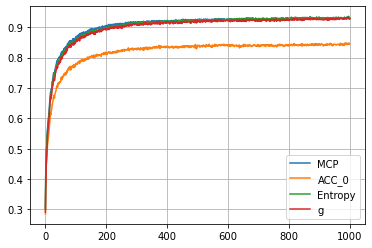

In [14]:
plt.plot(model_trainer_h.hist_val.acc_c_mcp,label = 'MCP')
plt.plot(model_trainer_h.hist_val.acc_list,label = 'ACC_0')
plt.plot(model_trainer_h.hist_val.acc_c_entropy,label = 'Entropy')
plt.plot(model_trainer_h.hist_val.acc_c_g, label = 'g')
plt.grid()
plt.legend()
plt.show()

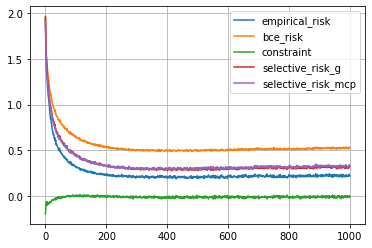

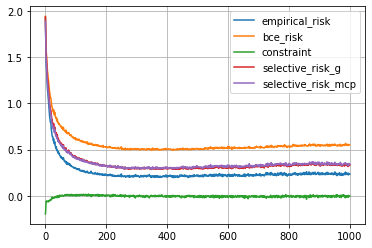

In [15]:
for key in risk_dict:
    plt.plot(model_trainer_h.hist_val.risk[key],label = key)

plt.grid()
plt.legend()
plt.show()

for key in risk_dict:
    plt.plot(model_trainer_f.hist_val.risk[key],label = key)

plt.grid()
plt.legend()
plt.show()